In [ ]:
import json
import os
import math
import librosa

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/genres"
JSON_PATH = "genres_data.json"
SAMPLE_RATE = 22050 #стандартное значение для обработки аудио
TRACK_DURATION = 30 # длительность треков
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION #всего измерений для трека

In [ ]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        """

    # Формат для структурированного хранения данных
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments) # количество измерений на один сегмент
    expected_num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length) #количество измерений для каждого вектора mfcc, они должны быть одинаковые, для точности 

    # проходим по всем жанрам внутри главной дериктории
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # проверка что мы не в корневой директории  
        if dirpath is not dataset_path:

            # сохраняем название жанра в файл
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # проходим по всем песням в папке жанра 
            for f in filenames:

		# загружаем аудио файл в json
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # обрабатываем каждый сегмент определенного аудио файла
                for s in range(num_segments):

                    # расчитываем начало и конец каждого сегмента 
                    start = samples_per_segment * s
                    finish = start + samples_per_segment

                    # вытаскиваем mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # сохраняем только те mfcc, что имеют нужную размерность векторов (нужно для точности)
                    if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, s+1))

    # сохраняем mfcc в json файл
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

Сверточная нейронная сеть


In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import random

import librosa
import math

In [ ]:
DATA_PATH = "/content/drive/MyDrive/AI Project /genres_data.json"

In [ ]:
def load_data(data_path):

    with open(data_path, "r") as f:
        data = json.load(f)

    # конвертирую листы numpy в массивы
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # для графика точности
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # для графика потерь
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


In [ ]:
X, y = load_data(DATA_PATH)

Data succesfully loaded!


In [ ]:
# делим данные на train, validation и test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

# добавляем оси для входящих данных 
X_train = X_train[..., np.newaxis] 
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
X_train.shape

(5997, 130, 13, 1)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
# build the CNN
model_cnn = keras.Sequential()

# 1st conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')) #добавляем нолики
model_cnn.add(keras.layers.BatchNormalization()) #магия чтоб работала быстро 

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3)) # игнорируем некоторые нейроны чтоб не получить overfitting 

# output layer
model_cnn.add(keras.layers.Dense(10, activation='softmax')) # 0-`, где сумма всех результатов была 1

In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',  # categorical_crossentropy есть еще такая
              metrics=['accuracy'])

In [ ]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 1, 32)        

In [ ]:
# train model
history = model_cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

Epoch 1/50
188/188 [==============================] - 13s 65ms/step - loss: 2.3688 - accuracy: 0.2263 - val_loss: 1.7629 - val_accuracy: 0.3907
Epoch 2/50
188/188 [==============================] - 12s 64ms/step - loss: 1.8507 - accuracy: 0.3513 - val_loss: 1.5028 - val_accuracy: 0.4647
Epoch 3/50
188/188 [==============================] - 12s 64ms/step - loss: 1.6677 - accuracy: 0.4042 - val_loss: 1.4003 - val_accuracy: 0.4980
Epoch 4/50
188/188 [==============================] - 12s 65ms/step - loss: 1.5221 - accuracy: 0.4562 - val_loss: 1.3107 - val_accuracy: 0.5320
Epoch 5/50
188/188 [==============================] - 12s 64ms/step - loss: 1.4499 - accuracy: 0.4764 - val_loss: 1.2515 - val_accuracy: 0.5473
Epoch 6/50
188/188 [==============================] - 12s 64ms/step - loss: 1.3939 - accuracy: 0.5014 - val_loss: 1.2039 - val_accuracy: 0.5613
Epoch 7/50
188/188 [==============================] - 12s 64ms/step - loss: 1.3200 - accuracy: 0.5218 - val_loss: 1.1636 - val_accuracy:

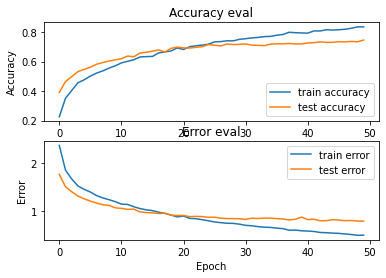

In [ ]:
# plot accuracy and error as a function of the epochs
plot_history(history)

In [ ]:

# evaluate model on Test Set
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

79/79 - 1s - loss: 0.7545 - accuracy: 0.7475

Test accuracy: 0.7474989891052246


In [ ]:
model_cnn.save("Music_Genre_10_CNN")

INFO:tensorflow:Assets written to: Music_Genre_10_CNN/assets


Предсказания

In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

In [ ]:
X_to_predict.shape

(130, 13, 1)

In [ ]:

print("Real Genre:", y_to_predict)

Real Genre: 2


In [ ]:
# add a dimension to input data for sample - model.predict() expects a 4d array in this case
X_to_predict = X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [ ]:
X_to_predict.shape

(1, 130, 13, 1)

In [ ]:
# perform prediction
prediction = model_cnn.predict(X_to_predict)

In [ ]:
# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))

Predicted Genre: 2


In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[50]
y_to_predict = y_test[50]

print("Real Genre:", y_to_predict)

X_to_predict = X_to_predict[np.newaxis, ...]

prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))

Real Genre: 9
Predicted Genre: 9


In [ ]:
len(X_test)

2499

In [ ]:
for n in range(10):

  i = random.randint(0,len(X_test))
  # pick a sample to predict from the test set
  X_to_predict = X_test[i]
  y_to_predict = y_test[i]

  print("\nReal Genre:", y_to_predict)

  X_to_predict = X_to_predict[np.newaxis, ...]

  prediction = model_cnn.predict(X_to_predict)

  # get index with max value
  predicted_index = np.argmax(prediction, axis=1)

  print("Predicted Genre:", int(predicted_index))


Real Genre: 6
Predicted Genre: 4

Real Genre: 6
Predicted Genre: 6

Real Genre: 8
Predicted Genre: 8

Real Genre: 9
Predicted Genre: 9

Real Genre: 4
Predicted Genre: 2

Real Genre: 9
Predicted Genre: 4

Real Genre: 1
Predicted Genre: 1

Real Genre: 7
Predicted Genre: 7

Real Genre: 7
Predicted Genre: 7

Real Genre: 0
Predicted Genre: 0


Предсказания для новой песни


In [ ]:
# Audio files pre-processing
def process_input(audio_file, track_duration):

  SAMPLE_RATE = 22050
  NUM_MFCC = 13
  N_FTT=2048
  HOP_LENGTH=512
  TRACK_DURATION = track_duration # measured in seconds
  SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
  NUM_SEGMENTS = 10

  samples_per_segment = int(SAMPLES_PER_TRACK / NUM_SEGMENTS)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

  signal, sample_rate = librosa.load(audio_file, sr=SAMPLE_RATE)
  
  for d in range(10):

    # calculate start and finish sample for current segment
    start = samples_per_segment * d
    finish = start + samples_per_segment

    # extract mfcc
    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FTT, hop_length=HOP_LENGTH)
    mfcc = mfcc.T

    return mfcc

In [ ]:
genre_dict = {0:"jazz",1:"classical",2:"blues",3:"hiphop",4:"country",5:"pop",6:"rock",7:"metal",8:"disco",9:"reggae"} 

In [ ]:
new_input_mfcc = process_input("/content/drive/MyDrive/AI Project /classical.mp3", 30)

In [ ]:
type(new_input_mfcc)

numpy.ndarray

In [ ]:
new_input_mfcc.shape

(130, 13)

In [ ]:
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape

(1, 130, 13, 1)

In [ ]:
prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", genre_dict[int(predicted_index)])

Predicted Genre: hiphop


In [ ]:
new_input_mfcc = process_input("/content/drive/MyDrive/AI Project /blues3.mp3", 30)

In [ ]:
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape

(1, 130, 13, 1)

In [ ]:
prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", genre_dict[int(predicted_index)])

Predicted Genre: blues
